In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import cv2

dir = "./yale_face_dataset"
path = pathlib.Path(dir)
images = list(path.glob("*"))
images = [str(file) for file in images]

print(len(images))

165


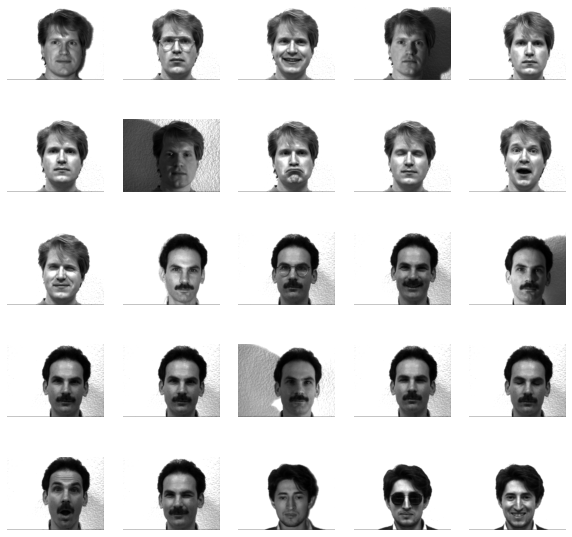

In [2]:
# Helper function to read data
def readImage(path):
    img = imread(path)

    return img

# Visualise some of the data
plt.figure(figsize=(10,10))
rows = 5
cols = 5
for i in range(1, (rows*cols)+1):
    img = readImage(images[i-1])
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

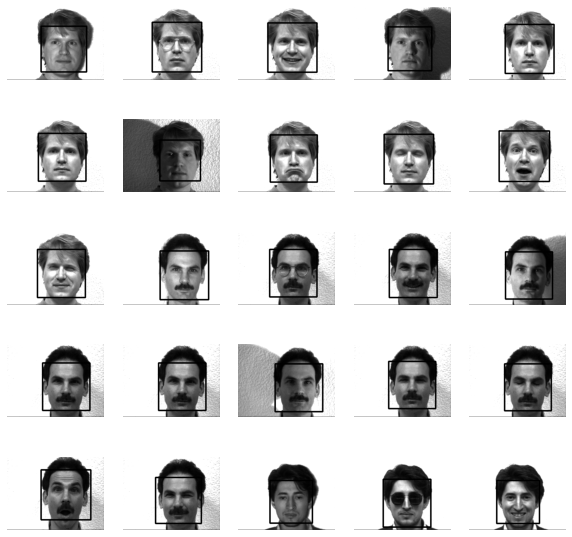

In [3]:
# Face detection with OpenCV
# Helper function to read image and perform face detection
def readImage_detectFace(path):
    img = imread(path)

    faceCascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(img)

    return img, faces

# Visualise the face detection algorithm
plt.figure(figsize=(10,10))
rows = 5
cols = 5
for i in range(1, (rows*cols)+1):
    img, faces = readImage_detectFace(images[i-1])
    for face in faces:
        x1, y1, w, h = face
        x2 = x1 + w
        y2 = y1 + h

        # Draw bounding box around face
        cv2.rectangle(img, (x1,y1), (x2,y2), 0, 3)

    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
# Helper function to overlap cap image on face image
def overlay_image_alpha(img, img_overlay, pos, alpha_mask):
    """Overlay img_overlay on top of img at the position specified by
    pos and blend using alpha_mask.

    Alpha mask must contain values within the range [0, 1] and be the
    same size as img_overlay.
    """

    x, y = pos

    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    #channels = img.shape[2]
    channels = 1

    alpha = alpha_mask[y1o:y2o, x1o:x2o]
    alpha_inv = 1.0 - alpha

    img[y1:y2, x1:x2] = (alpha * img_overlay[y1o:y2o, x1o:x2o] +
                                alpha_inv * img[y1:y2, x1:x2])

    return img

    # for c in range(channels):
    #     img[y1:y2, x1:x2, c] = (alpha * img_overlay[y1o:y2o, x1o:x2o, c] +
    #                             alpha_inv * img[y1:y2, x1:x2, c])

In [5]:
import xml.etree.ElementTree as ET

caps_dir = "./caps/"
caps_xml = ET.parse(caps_dir+"caps.xml")
caps = caps_xml.findall('cap')

caps_filenames = [caps_dir+cap.find('filename').text for cap in caps]
caps_centre = [float(cap.find('centre').text) for cap in caps]

print(caps_filenames)
print(caps_centre)

['./caps/cap_front.png', './caps/cap_frontleft.png', './caps/cap_frontright.png', './caps/cap_left.png', './caps/cap_right.png']
[0.5, 0.36, 0.6, 0.3, 0.65]


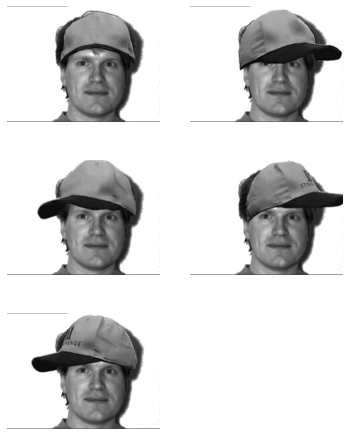

In [6]:
# Helper function for face-cap augmentation
# Grayscale only for Yale face dataset
def augmentCaponFace(img_path, cap_path, cap_c):
    img, faces = readImage_detectFace(img_path)
    
    for face in faces:
        x1, y1, w, h = face
        x2 = x1 + w
        y2 = y1 + h
        
        # load random cap image
        cap_img = cv2.imread(cap_path, cv2.IMREAD_UNCHANGED)

        # Resize cap based on size of bounding box
        dim = (int(w*1.6), int(h))
        cap_img = cv2.resize(cap_img, dim)
        cap_h, cap_w, cap_d = cap_img.shape

        cap_y1 = y1 - int(h*0.5)
        cap_x1 = x1 - int(w*(cap_c-0.2))

        cap_gray = cv2.cvtColor(cap_img[:,:,0:3], cv2.COLOR_BGR2GRAY)
        cap_alpha =  cap_img[:,:,3]/255.0
        img = overlay_image_alpha(img, cap_gray, (cap_x1, cap_y1), cap_alpha)

    return img

plt.figure(figsize=(6,8))
for i in range(len(caps_filenames)):
    img = augmentCaponFace(images[0], caps_filenames[i], caps_centre[i])

    plt.subplot(3, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

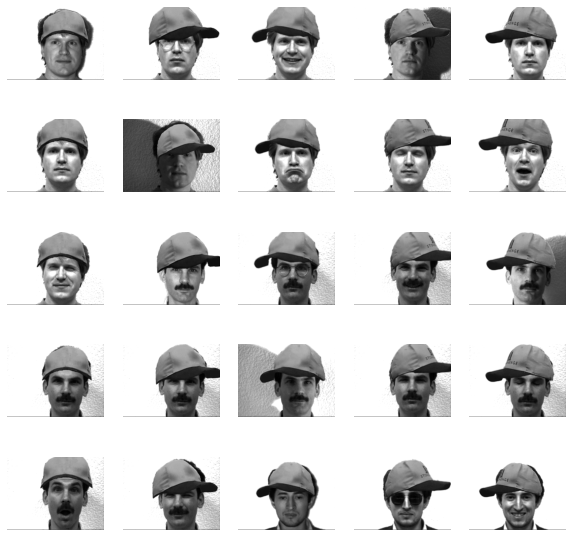

In [7]:
# Test augmentations on 16 images
# Visualise the augmentations, call helper function within visualisations
plt.figure(figsize=(10,10))
rows = 5
cols = 5
j = 0
for i in range(1, (rows*cols)+1):
    img = augmentCaponFace(images[i-1], caps_filenames[j], caps_centre[j])
    j = (j + 1) % len(caps_filenames)

    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [12]:
no_cap_dir = "./cap_nocap_dataset/nocap/"
for i in range(len(images)):
    no_cap_img = readImage(images[i])
    cv2.imwrite(no_cap_dir+str(i)+".jpg", no_cap_img)

In [12]:
cap_dir = "./cap_nocap_dataset/cap/"
j = 0
for i in range(0, len(images), 2):
    for j in range(len(caps_filenames)-2):
        cap_img = augmentCaponFace(images[i], caps_filenames[j], caps_centre[j])
        # j = (j + 1) % (len(caps_filenames)-2)
        cv2.imwrite(cap_dir+str(i)+"_"+str(j)+".jpg", cap_img)